# Simple hovercraft motion planning examples

In [1]:
using JuMP, Gurobi
using Plots, Measures, LaTeXStrings
using LinearAlgebra
using Random

cwd = pwd()
;

In [2]:
# continuous dynamics
A = [zeros(2, 2) diagm(ones(2)); zeros(2, 2) zeros(2, 2)]
B = [zeros(2, 2); diagm(ones(2))]
n = size(A)[1]
m = size(B)[2]

# convert to discrete
dt = 1
A = diagm(ones(n)) + dt .* A
B = dt .* B
;

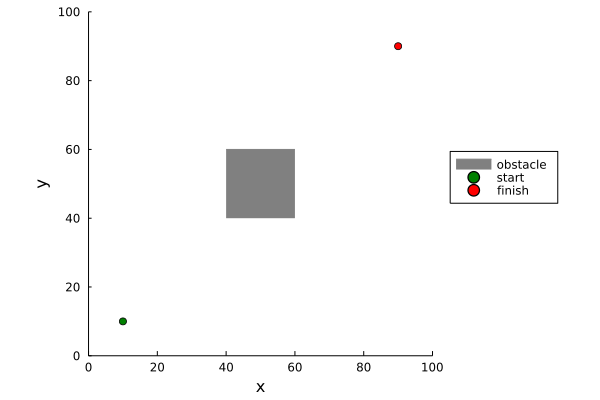

In [3]:
# visualize map
plot(range(40, 60, 3), range(60, 60, 3), fillrange=40, label="obstacle", color=:grey)
scatter!([10], [10], label="start", color=:green)
scatter!([90], [90], label="finish", color=:red)
plot!(legend_position=:outerright)
plot!(aspect_ratio=1)
plot!(grid=false)
xlabel!("x")
ylabel!("y")
xlims!(0, 100)
ylims!(0, 100)
savefig("figures/toy_world_layout.png")
plot!()

# Motion planning via MIP

In [4]:
# box constraints on variables
x_min = 0; x_max = 100
y_min = 0; y_max = 100
u_min = -1; u_max = 1

# start and stop values
x_start = [10, 10, 0, 0]
x_stop = [90, 90, 0, 0]
max_final_dist = 0

# obstacle halfspace parameters
a_1 = [0, 1]; b_1 = 40
a_2 = [0, -1]; b_2 = -60
a_3 = [1, 0]; b_3 = 40
a_4 = [-1, 0]; b_4 = -60
A_con = [a_1'; a_2'; a_3'; a_4']
b_con = [b_1, b_2, b_3, b_4]

# time horizon
T = 100
H = round(Int, T / dt)  # max number of timesteps

# large arbitrary number
M = 100

println("Number of timesteps: ", H)
;

Number of timesteps: 100


In [5]:
# warm-start the optimization problem
# initialize x, u to be a direct trajectory (ignoring obstacles) from start to 
# goal. can do this by solving optimization problem (easier) or analytically 
# (would be easy with this hovercraft, not so easy to find initial feasible 
# values for systems with more complex dynamics)

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)
println()

@variable(model, x_ws[1:n, 1:H])
@variable(model, u_ws[1:m, 1:H-1])
@variable(model, z_ws[1:size(A_con)[1], 1:H], Bin)

# starting and ending configurations
@constraint(model, x_ws[:, 1] .== x_start)
@constraint(model, [max_final_dist; x_ws[:, H] - x_stop] in SecondOrderCone())

# box constraints on state and control
@constraint(model, x_min .<= x_ws[1, :] .<= x_max)
@constraint(model, y_min .<= x_ws[2, :] .<= y_max)
@constraint(model, u_min .<= u_ws .<= u_max)

# dynamics constraint
for i = 1:H-1
    @constraint(model, x_ws[:, i+1] .== A*x_ws[:, i] + B*u_ws[:, i])
end

@expression(model, total_energy, sum(u_ws[:, i]'*u_ws[:, i] for i in 1:H-1))
@objective(model, Min, total_energy)

@time(optimize!(model))
println(termination_status(model))
println(objective_value(model))

x_ws = value.(x_ws)
u_ws = value.(u_ws)
z_ws = value.(z_ws)
;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24

  2.946969 seconds (9.10 M allocations: 547.575 MiB, 5.48% gc time, 99.71% compilation time)
OPTIMAL
0.158317872597677


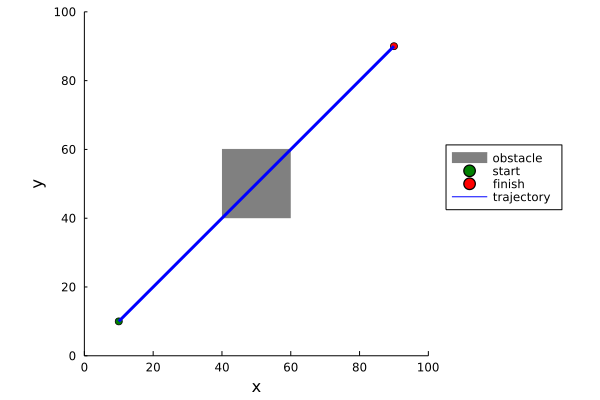

In [6]:
# visualize result
plot(range(40, 60, 2), range(60, 60, 2), fillrange=40, label="obstacle", color=:grey)
scatter!([10], [10], label="start", color=:green)
scatter!([90], [90], label="finish", color=:red)
plot!(legend_position=:outerright)
plot!(aspect_ratio=1)
plot!(grid=false)
xlabel!("x")
ylabel!("y")
xlims!(0, 100)
ylims!(0, 100)
plot!(x_ws[1, :], x_ws[2, :], label="trajectory", line=(3, :blue))
savefig("figures/toy_world_solved.png")
plot!()

In [7]:
# now solve the real problem, but with initial values

new_model = Model(Gurobi.Optimizer)
set_optimizer_attribute(new_model, "OutputFlag", 0)
println()

println("Number of timesteps: ", H)

@variable(new_model, x[1:n, 1:H])
@variable(new_model, u[1:m, 1:H-1])
@variable(new_model, z[1:size(A_con)[1], 1:H], Bin)

# warm-start the optimization problem
set_start_value.(x, x_ws)
set_start_value.(u, u_ws)
set_start_value.(z, z_ws)

# starting and ending configurations
@constraint(new_model, x[:, 1] .== x_start)
@constraint(new_model, [max_final_dist; x[:, H] - x_stop] in SecondOrderCone())

# box constraints on state and control
@constraint(new_model, x_min .<= x[1, :] .<= x_max)
@constraint(new_model, y_min .<= x[2, :] .<= y_max)
@constraint(new_model, u_min .<= u .<= u_max)

# dynamics constraint
for i = 1:H-1
    @constraint(new_model, x[:, i+1] .== A*x[:, i] + B*u[:, i])
end

# avoid obstacles
for i in 1:H
    @constraint(new_model, A_con*x[1:2, i] - b_con .<= (1 .- z[:, i]) * M)
    @constraint(new_model, sum(z[:, i]) >= 1)
end

λ = .01
@expression(new_model, total_energy, sum(u[:, i]'*u[:, i] for i in 1:H-1))
@expression(new_model, final_dist, (x[:, H] - x_stop)'*(x[:, H] .- x_stop))
@objective(new_model, Min, total_energy)
# @objective(new_model, Min, final_dist)
# @objective(new_model, Min, total_energy + λ*final_dist)

@time(optimize!(new_model))
println(termination_status(new_model))
println(objective_value(new_model))

x_opt = value.(x)
u_opt = value.(u)
z_opt = value.(z)
;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24

Number of timesteps: 100
  0.411392 seconds (297.26 k allocations: 16.064 MiB, 62.21% compilation time)
OPTIMAL
0.19339857897092294


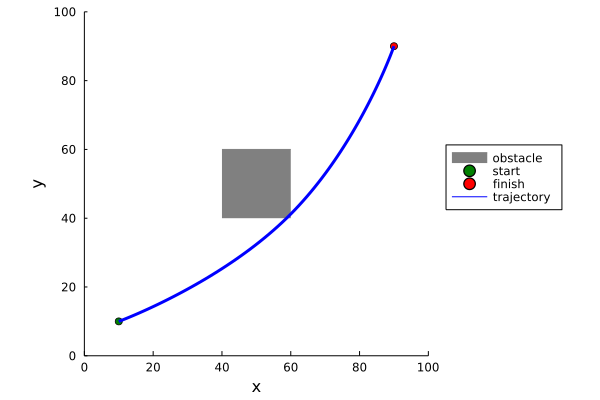

In [8]:
# visualize result
plot(range(40, 60, 2), range(60, 60, 2), fillrange=40, label="obstacle", color=:grey)
scatter!([10], [10], label="start", color=:green)
scatter!([90], [90], label="finish", color=:red)
plot!(legend_position=:outerright)
plot!(aspect_ratio=1)
plot!(grid=false)
xlabel!("x")
ylabel!("y")
xlims!(0, 100)
ylims!(0, 100)
plot!(x_opt[1, :], x_opt[2, :], label="trajectory", line=(3, :blue))
savefig("figures/toy_world_solved.png")
plot!()

## Multi-vehicle motion planning via MIP

In [9]:
# multiple vehicles (obstacle remains the same)
N = 2  # number of vehicles

# start and stop values
x_start = [5 10 0 0; 10 10 0 0; 15 10 0 0]
x_stop = [90, 90, 0, 0]

# safe distance for vehicles to maintain (creates box around each vehicle)
x_safe = 5
y_safe = 5

# want them to travel as convoy
max_dist = 10

println("Number of timesteps: ", H)

Number of timesteps: 100


In [10]:
# warm-start the optimization problem
# initialize x, u to be a direct trajectory (ignoring obstacles and other 
# constraints) from start to goal

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)
println()

@variable(model, x[1:N, 1:n, 1:H])
@variable(model, u[1:N, 1:m, 1:H-1])
@variable(model, z[1:N, 1:size(A_con)[1], 1:H], Bin)  # obstacle avoid var
@variable(model, w[1:N, 1:N, 1:H, 1:n], Bin)          # avoid each other var

# starting and ending configurations
for i = 1:N
    @constraint(model, x[i, :, 1] .== x_start[i, :])
    @constraint(model, [max(x_safe, y_safe); x[i, :, H] - x_stop[:]] in SecondOrderCone())
end

# box constraints on state and control (not needed)
@constraint(model, x_min .<= x[:, 1, :] .<= x_max)
@constraint(model, y_min .<= x[:, 2, :] .<= y_max)
@constraint(model, u_min .<= u .<= u_max)

# dynamics constraint
for i = 1:N
    for k = 1:H-1
        @constraint(model, x[i, :, k+1] .== A*x[i, :, k] + B*u[i, :, k])
    end
end

@expression(model, total_energy, sum(u[i, :, k]'*u[i, :, k] for i in 1:N, k in 1:H-1))
@objective(model, Min, total_energy)

@time(optimize!(model))
println(termination_status(model))
println(objective_value(model))

x_ws = value.(x)
u_ws = value.(u)
z_ws = value.(z)
w_ws = value.(w)
;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24

  0.018672 seconds (77.83 k allocations: 5.326 MiB)
OPTIMAL
0.07629596710668615


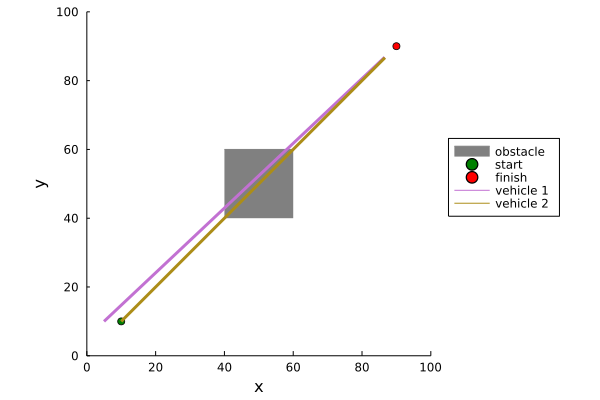

In [11]:
# visualize result
plot(range(40, 60, 2), range(60, 60, 2), fillrange=40, label="obstacle", color=:grey)
scatter!([10], [10], label="start", color=:green)
scatter!([90], [90], label="finish", color=:red)
plot!(legend_position=:outerright)
plot!(aspect_ratio=1)
plot!(grid=false)
xlabel!("x")
ylabel!("y")
xlims!(0, 100)
ylims!(0, 100)
for i in 1:N
    plot!(x_ws[i, 1, :], x_ws[i, 2, :], label="vehicle $i", line=(3))
end
savefig("figures/toy_world_multi_solved.png")
plot!()

In [12]:
# solve the actual optimization problem

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)
println()

@variable(model, x[1:N, 1:n, 1:H])
@variable(model, u[1:N, 1:m, 1:H-1])
@variable(model, z[1:N, 1:size(A_con)[1], 1:H], Bin)  # obstacle avoid var
@variable(model, w[1:N, 1:N, 1:H, 1:n], Bin)          # avoid each other var

# warm-start the optimization problem
set_start_value.(x, x_ws)
set_start_value.(u, u_ws)
set_start_value.(z, z_ws)
set_start_value.(w, w_ws)

# starting and ending configurations
for i = 1:N
    @constraint(model, x[i, :, 1] .== x_start[i, :])
    @constraint(model, [max(x_safe, y_safe); x[i, :, H] - x_stop[:]] in SecondOrderCone())
end

# box constraints on state and control (not needed)
@constraint(model, x_min .<= x[:, 1, :] .<= x_max)
@constraint(model, y_min .<= x[:, 2, :] .<= y_max)
@constraint(model, u_min .<= u .<= u_max)

# dynamics constraint
for i = 1:N
    for k = 1:H-1
        @constraint(model, x[i, :, k+1] .== A*x[i, :, k] + B*u[i, :, k])
    end
end

# avoid obstacles
for i = 1:N
    for k in 1:H
        @constraint(model, A_con*x[i, 1:2, k] .- b_con .<= (1 .- z[i, :, k]) .* M)
        @constraint(model, sum(z[i, :, k]) >= 1)
    end
end

# avoid one another
for i = 1:N
    for j = (i+1):N
        for k = 1:H
            @constraint(model, x[i, 1, k] - x[j, 1, k] >= x_safe - (1 - w[i, j, k, 1]) * M)
            @constraint(model, x[j, 1, k] - x[i, 1, k] >= x_safe - (1 - w[i, j, k, 2]) * M)
            @constraint(model, x[i, 2, k] - x[j, 2, k] >= y_safe - (1 - w[i, j, k, 3]) * M)
            @constraint(model, x[j, 2, k] - x[i, 2, k] >= y_safe - (1 - w[i, j, k, 4]) * M)
            @constraint(model, sum(w[i, j, k, :]) >= 1)
        end
    end
end

# but stay close-ish to one another
for i = 1:N
    for j = (i+1):N
        for k = 1:H
            @constraint(model, [max_dist; x[i, 1:2, k] - x[j, 1:2, k]] in SecondOrderCone())
        end
    end
end

# @expression(model, finl_dist, sum((x[r, :, N] .- x_stop)'*(x[r, :, N] .- x_stop) for r in 1:R))
@expression(model, total_energy, sum(u[i, :, k]'*u[i, :, k] for i in 1:N, k in 1:H-1))
# @objective(model, Min, total_energy + final_dist)
@objective(model, Min, total_energy)
# @objective(model, Min, final_dist)

@time(optimize!(model))
println(termination_status(model))
println(objective_value(model))

x_opt = value.(x)
u_opt = value.(u)
z_opt = value.(z)
w_opt = value.(w)
;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-24

 45.623431 seconds (208.03 k allocations: 10.796 MiB)
OPTIMAL
0.10813040062626832


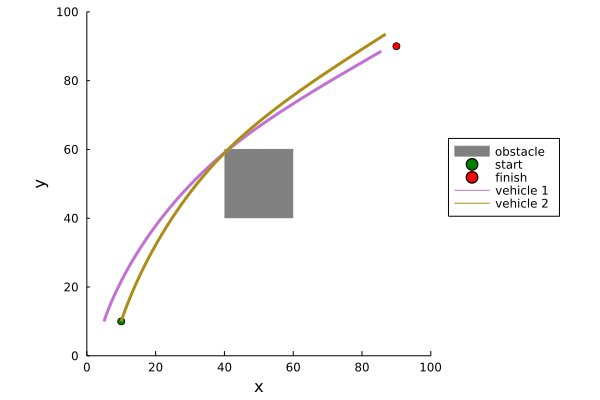

In [13]:
# visualize result
plot(range(40, 60, 2), range(60, 60, 2), fillrange=40, label="obstacle", color=:grey)
scatter!([10], [10], label="start", color=:green)
scatter!([90], [90], label="finish", color=:red)
plot!(legend_position=:outerright)
plot!(aspect_ratio=1)
plot!(grid=false)
xlabel!("x")
ylabel!("y")
xlims!(0, 100)
ylims!(0, 100)
for i in 1:N
    plot!(x_opt[i, 1, :], x_opt[i, 2, :], label="vehicle $i", line=(3))
end
savefig("figures/toy_world_multi_solved.png")
plot!()